# 1. Setup

In [ ]:
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))

In [ ]:
# Horizontal Scrolling
import io
import base64
from IPython.display import HTML, display

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.ndimage import binary_dilation
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from pandas import DataFrame, Series, Timedelta

In [ ]:
from utils.loading import load_all_raw_data
from utils.preprocessing import process_all_dfs
from utils.merging import merge_all_dfs
from utils.feature_engineering import *

In [ ]:
pd.set_option(
    "display.float_format",
    lambda x: f"{x:.2e}" if abs(x) < 0.01 and x != 0 else f"{x:.2f}",
)
pd.set_option('display.max_columns', 100)
pd.set_option("display.max_rows", 100)

In [ ]:
SEGMENT_C = ["county", "product_type", "is_business"]
CATEGORICAL_C = ["county", "product_type", "is_business", "is_consumption"]
TARGET_C = [
    "county",
    "product_type",
    "is_business",
    "is_consumption",
    "datetime",
]
RAND = 10

In [ ]:
RAW_DATA_PATH = "../raw_data/"
ADDITIONAL_DATA_PATH = "../additional_data/"

# 2. Processing

In [ ]:
processed_dfs = process_all_dfs(
    load_all_raw_data(RAW_DATA_PATH, ADDITIONAL_DATA_PATH)
)

In [ ]:
processed_dfs.keys()

dict_keys(['train', 'gas_prices', 'client', 'electricity_prices', 'forecast_weather', 'historical_weather', 'station_county_mapping', 'county_id_to_name_map', 'holidays'])

In [ ]:
df = merge_all_dfs(processed_dfs, how="left")

In [ ]:
df = add_dst_flag(df)

In [ ]:
df = add_cyclic_datetime_features(df, drop_raw=True)

In [ ]:
# for lag in [2, 3, 7]:
for lag in range(2, 15):
    df = df.merge(
        get_lag(processed_dfs["train"][TARGET_C + ["target"]], lag=lag),
        on=TARGET_C,
    )

In [ ]:
# for window in [24, 24 * 3, 24 * 7, 24 * 14]:
for window in [24 * i for i in range(1, 15)]:
    df = df.merge(
        get_moving_average(
            processed_dfs["train"]
            .set_index("datetime")
            .sort_index()
            .groupby(CATEGORICAL_C, observed=True, as_index=False),
            window=window,
        ).dropna(),
        on=TARGET_C,
    )

In [ ]:
df["t_over_cap"] = (df["2d_lag_target"] / df["installed_capacity"]).astype(
    "float32"
)
df["t_over_eic"] = (df["2d_lag_target"] / df["eic_count"]).astype("float32")
df["cap_per_eic"] = (df["installed_capacity"] / df["eic_count"]).astype(
    "float32"
)

In [ ]:
# w, h = 20, 14

# fig, ax = plt.subplots(figsize=(w, h))
# # plt.figure(figsize=(w, h))

# sns.heatmap(
#     df.drop(
#         columns=df.select_dtypes(["category"]).columns.tolist()
#         + [
#             "datetime",
#             "data_block_id",
#             "date",
#         ]
#     ).corr(),
#     annot=True,
#     fmt=".1f",
#     annot_kws={"size": 7},
# )


# buf = io.BytesIO()
# fig.savefig(buf, format="png", bbox_inches="tight")
# buf.seek(0)
# img_base64 = base64.b64encode(buf.getvalue()).decode("utf-8")

# html_code = (
#     '<div style="overflow-x: auto; width: 100%;">'
#     '<img src="data:image/png;base64,{}" style="display: block; max-width: none; width: auto;">'
#     "</div>"
# ).format(img_base64)

# display(HTML(html_code))
# plt.close(fig)
# # plt.show()

# 3. Cross Validation

In [ ]:
FEATURES_TO_DROP = ["datetime", "data_block_id", "date"]

In [ ]:
df["datetime"].is_monotonic_increasing

True

In [ ]:
# df = df.sort_values('datetime', ignore_index=True)

In [ ]:
df["datetime"].dt.date.iloc[0]

datetime.date(2021, 9, 17)

In [ ]:
df["datetime"].max()- pd.Timedelta(days=1)

Timestamp('2023-05-30 23:00:00')

In [ ]:
df["datetime"].dt.floor("d").max()
# - pd.Timedelta(days=1)

Timestamp('2023-05-31 00:00:00')

In [ ]:
df["datetime"].dt.floor("d")

0         2021-09-17
1         2021-09-17
2         2021-09-17
3         2021-09-17
4         2021-09-17
             ...    
1865113   2023-05-31
1865114   2023-05-31
1865115   2023-05-31
1865116   2023-05-31
1865117   2023-05-31
Name: datetime, Length: 1865118, dtype: datetime64[ns]

In [ ]:
# def split_by_equal_days(
#     df: DataFrame,
#     dt: str = "datetime",
#     train_days: int = 1,
#     fh_days: int = 1,  # Same for val and test
#     # step_days: int,
#     val_steps: int = 1,
#     expanding: bool = True,
# ):
#     dt = df[dt].dt.floor("D")
    
#     train_days_delta = Timedelta(days=train_days - 1)  # Indexing from 0
#     fh_days = Timedelta(days=fh_days)

#     first_day = dt.min()
#     last_day = dt.max()
#     test_start = last_day - fh_days
#     test_end = last_day + pd.Timedelta(hours=23)

#     splits = []

#     for step in range(val_steps + 1): # val_steps times + 1 test-only
#         if expanding:
#             train_start = first_day
#         else:
#             train_start = first_day + step * fh_days

#         train_end = train_start + train_days_delta + pd.Timedelta(hours=23)
#         val_start = train_end + pd.Timedelta(hours=1)
#         val_end = val_start + fh_days - pd.Timedelta(hours=1)

#         if val_end >= test_start:
#             # Skip creating val if it overlaps with test
#             splits.append({
#                 "train": (train_start, train_end),
#                 "val": None,
#                 "test": (test_start, test_end),
#             })
#             break

#         splits.append({
#             "train": (train_start, train_end),
#             "val": (val_start, val_end),
#             "test": (test_start, test_end),
#         })

#     return splits

In [ ]:
splits = split_by_equal_days(
    df, "datetime", train_days=180, fh_days=1, val_steps=2, expanding=False
)

In [ ]:
df["datetime"].min()

Timestamp('2021-09-17 00:00:00')

In [ ]:
df["datetime"].max()

Timestamp('2023-05-31 23:00:00')

In [ ]:
train_ts = "2022-06-01 00:00:00"
val_ts = "2022-07-01 00:00:00"
test_ts = "2022-08-01 00:00:00"

In [ ]:
# example_df = df.loc[df["datetime"] < test_timestamp]

In [ ]:
df_train = df[df["datetime"] < train_ts].drop(FEATURES_TO_DROP, axis=1)
df_val = df[
    (df["datetime"] >= train_ts) & (df["datetime"] < val_ts)
].drop(FEATURES_TO_DROP, axis=1)
df_test = df[
    (df["datetime"] >= val_ts) & (df["datetime"] < test_ts)
].drop(FEATURES_TO_DROP, axis=1)

X_train, y_train = df_train.drop(["target"], axis=1), df_train["target"]
X_val, y_val = df_val.drop(["target"], axis=1), df_val["target"]
X_test, y_test = df_test.drop(["target"], axis=1), df_test["target"]

In [ ]:
eval_set = [(X_train, y_train), (X_val, y_val)]

In [ ]:
n_estimators = 1000
max_depth=5
early_stopping_rounds = 100
learning_rate = 0.1

In [ ]:
xgbr = XGBRegressor(
    n_estimators=n_estimators,
    max_depth=max_depth,
    random_state=RAND,
    enable_categorical=True,
    eval_metric="mae",
    early_stopping_rounds=early_stopping_rounds,
    learning_rate=learning_rate,
)

In [ ]:
xgbr.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    verbose=True
)

[0]	validation_0-mae:311.95598	validation_1-mae:289.44766
[1]	validation_0-mae:282.72383	validation_1-mae:263.74130
[2]	validation_0-mae:256.59013	validation_1-mae:241.11494
[3]	validation_0-mae:233.10433	validation_1-mae:220.89006
[4]	validation_0-mae:212.15127	validation_1-mae:202.99557
[5]	validation_0-mae:193.38201	validation_1-mae:187.50081
[6]	validation_0-mae:176.68543	validation_1-mae:173.39250
[7]	validation_0-mae:161.67524	validation_1-mae:161.03157
[8]	validation_0-mae:148.17914	validation_1-mae:150.17820
[9]	validation_0-mae:136.22327	validation_1-mae:140.49477
[10]	validation_0-mae:125.51930	validation_1-mae:131.91433
[11]	validation_0-mae:115.96422	validation_1-mae:124.51822
[12]	validation_0-mae:107.44054	validation_1-mae:117.94968
[13]	validation_0-mae:99.79786	validation_1-mae:111.86825
[14]	validation_0-mae:93.05689	validation_1-mae:106.99227
[15]	validation_0-mae:87.15621	validation_1-mae:102.57430
[16]	validation_0-mae:81.75423	validation_1-mae:98.66815
[17]	validat

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=100,
             enable_categorical=True, eval_metric='mae', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

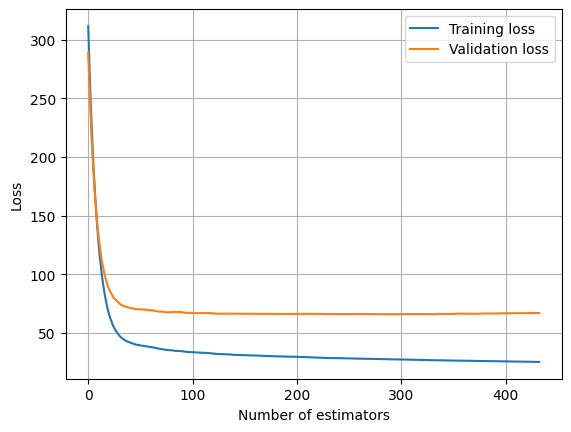

In [ ]:
results = xgbr.evals_result()

plt.plot(results["validation_0"]["mae"], label="Training loss")
plt.plot(results["validation_1"]["mae"], label="Validation loss")

plt.xlabel("Number of estimators")
plt.ylabel("Loss")

plt.legend()
# plt.yscale("log")
plt.grid(which='both')

plt.show()

In [ ]:
y_pred = xgbr.predict(X_test)

In [ ]:
mean_absolute_error(y_test, y_pred)

60.26907730102539

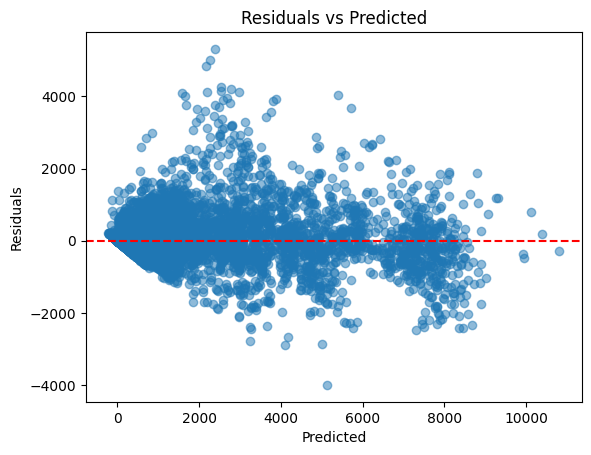

In [ ]:
residuals = y_test - y_pred

plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()

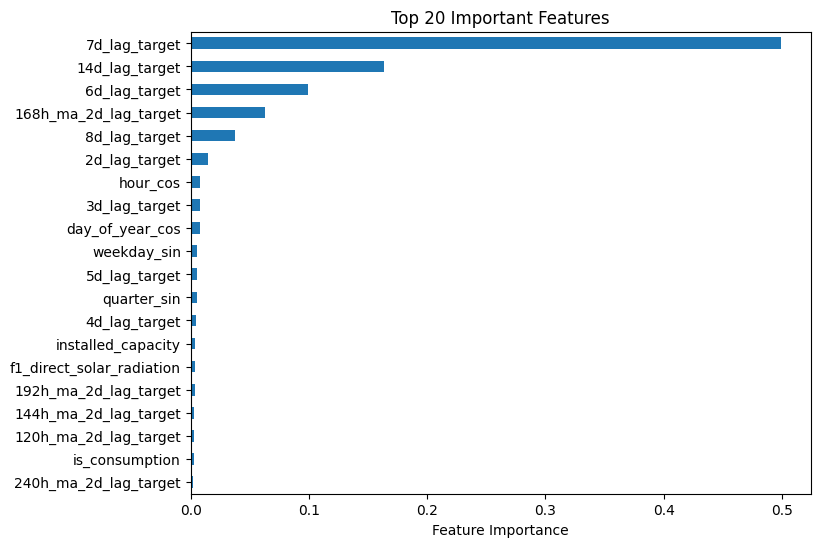

In [ ]:
fi = pd.Series(xgbr.feature_importances_, index=X_train.columns)
fi = fi.sort_values(ascending=False).head(20)

fi.plot.barh(figsize=(8,6))
plt.xlabel("Feature Importance")
plt.gca().invert_yaxis()
plt.title("Top 20 Important Features")
plt.show()